# A note on random numbers and dimensionality

#### Setup

Import QuantLib and the graphing module.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from QuantLib import *

Also, define a helper function to make the notebook less verbose.

In [2]:
def set_unit_square(ax):
    ax.axis('scaled')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

#### Covering a unit square

Let's say we want to extract points inside a unit square; that is, pairs of points in the domain $(0,1) \times (0,1)$.  The dimensionality of the problem is 2, since we need 2 numbers, $x$ and $y$, per each sample.

With pseudo-random numbers, it doesn't matter much: we can just extract single numbers and form pairs from them.

In [3]:
rng = MersenneTwisterUniformRng(42)

In [4]:
xs = []
ys = []
for i in range(2047):
    xs.append(rng.next().value())
    ys.append(rng.next().value())

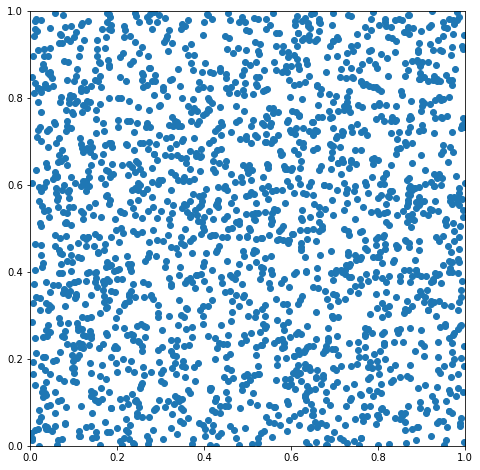

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
set_unit_square(ax)
ax.plot(xs,ys,'o');

The same doesn't hold for quasi-random numbers, for which each sample is correlated to the one that follows it in order to cover the domain evenly.  We can see this by plotting the sequence of Sobol numbers generated to cover the 1-dimensional unit interval:

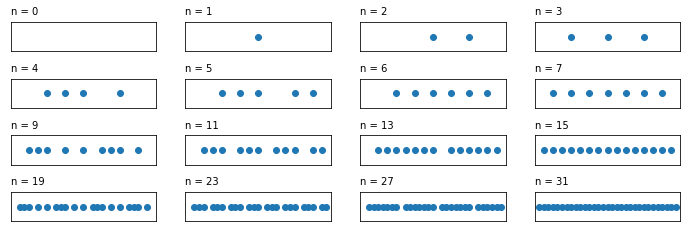

In [6]:
fig = plt.figure(figsize=(12,4))
for i, n in enumerate([0,1,2,3, 4,5,6,7, 9,11,13,15, 19,23,27,31]):
    rng = SobolRsg(1)
    xs = [ rng.nextSequence().value()[0] for j in range(n) ]
    ax = fig.add_subplot(4, 4, i+1)
    ax.axis('scaled')
    ax.set_xlim([0,1])
    ax.set_ylim([-0.1,0.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(xs,[0]*len(xs),'o')
    ax.text(0.0, 0.15, 'n = %d' % n)

The points are not added randomly at all, but in a predetermined sequence.  This ruins the random properties of the sequence when used with the wrong dimensionality.  (You can also see how an even coverage is only obtained for a number of samples of the form $n = 2^i -1$ for some $i$.)

In [7]:
rng = SobolRsg(1)

In [8]:
xs = []
ys = []
for i in range(2047):
    xs.append(rng.nextSequence().value()[0])
    ys.append(rng.nextSequence().value()[0])

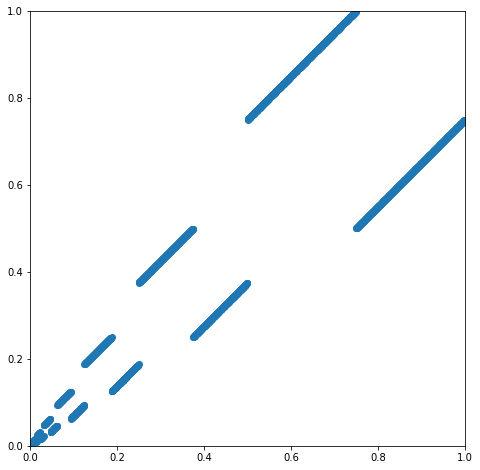

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
set_unit_square(ax)
ax.plot(xs,ys,'o');

To cover the domain correctly, we have to use the right dimensionality.

In [10]:
rng = SobolRsg(2)

In [11]:
xs = []
ys = []
for i in range(2047):
    x,y = rng.nextSequence().value()
    xs.append(x)
    ys.append(y)

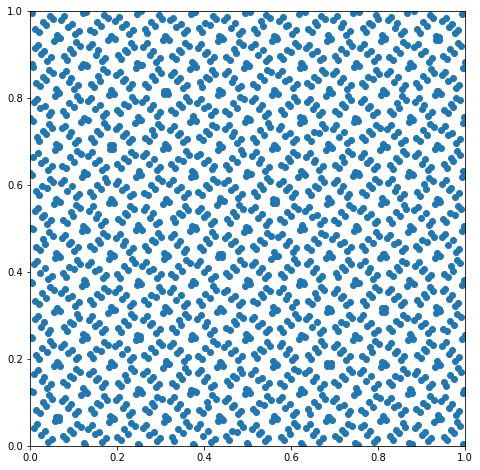

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
set_unit_square(ax)
ax.plot(xs,ys,'o');

The pattern above covers the square evenly, and also causes projections on the two axes to have good coverage (which wouldn't happen, for instance, with a regular placement in rows and columns; the projections of most points would coincide).  It is also interesting to see how the coverage is built as the number of samples increase:

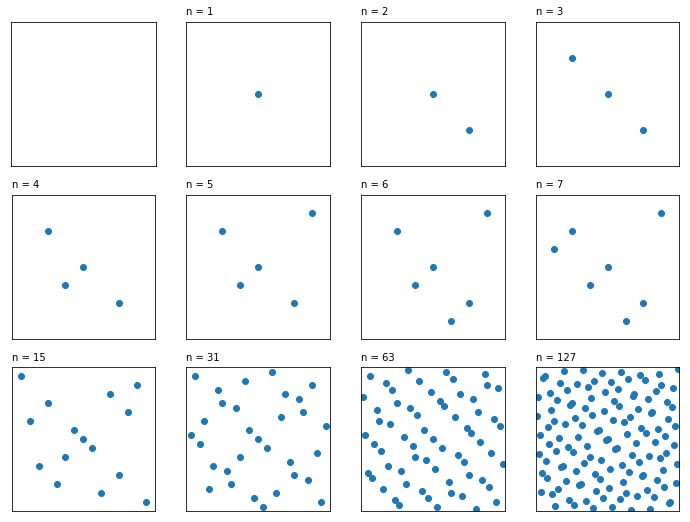

In [13]:
fig = plt.figure(figsize=(12,9))
for i, n in enumerate([0,1,2,3, 4,5,6,7, 15,31,63,127]):
    rng = SobolRsg(2)
    ax = fig.add_subplot(3, 4, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if n == 0:
        continue
    points = [ rng.nextSequence().value() for j in range(n) ]
    xs,ys = zip(*points)
    ax.axis('scaled')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot(xs,ys,'o')
    ax.text(0.0, 1.05, 'n = %d' % n)

#### Dimensionality of Monte Carlo simulations

The classes in the QuantLib Monte Carlo framework will check the dimensionality of the generators they're given and will warn you if it's not correct.  It's still up to you to find the correct one, while writing your engines (for details on that, you can check chapter 6 of [_Implementing QuantLib_](https://leanpub.com/implementingquantlib)).

For instance, let's say that you want to simulate three correlated stocks; and for sake of simplicity, let's say they follow the Black-Scholes process.  You'll build a process for each of them...

In [14]:
today = Date(27,January,2018)
Settings.instance().evaluationDate = today
risk_free = YieldTermStructureHandle(FlatForward(today, 0.01, Actual360()))

processes = [
    BlackScholesProcess(QuoteHandle(SimpleQuote(S)),
                        risk_free,
                        BlackVolTermStructureHandle(
                            BlackConstantVol(today, TARGET(), sigma, Actual360())))
    for S, sigma in [(100, 0.20),
                     ( 80, 0.25),
                     (110, 0.18)] ]

...and a single multi-dimensional process that correlates them.  In this case, the resulting process has three random drivers.

In [15]:
rho = [[1.0, 0.6, 0.8],
       [0.6, 1.0, 0.4],
       [0.8, 0.4, 1.0]]

process = StochasticProcessArray(processes, rho)
print(process.factors())

3


Now, let's say that we want to simulate paths over four steps, starting from today and ending one year from now.  Each sample of the Monte Carlo simulation will need three random number for each step, for a total of 12 random numbers.  This is the dimensionality of the problem; and, as I mentioned, the framework will check it and complain if it doesn't match.  (Please bear with me as I build the several classes needed for random-numbers generation.  If find yourself doing this, you might want to write a helper function, like I do here.)

In [16]:
def rng(dimensionality):
    return GaussianRandomSequenceGenerator(
             UniformRandomSequenceGenerator(
               dimensionality,
               UniformRandomGenerator(42)))

times = [0.25, 0.50, 0.75, 1.0]
generator = GaussianMultiPathGenerator(process, times, rng(10))

RuntimeError: dimension (10) is not equal to (3 * 4) the number of factors times the number of time steps

As you might expect, the thing works with the correct dimensionality:

In [17]:
generator = GaussianMultiPathGenerator(process, times, rng(12))

In [18]:
sample = generator.next().value()

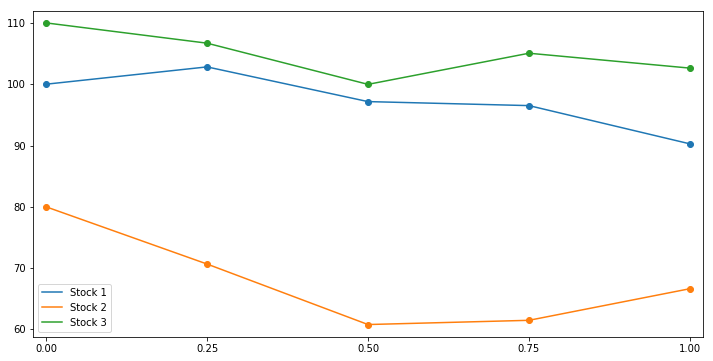

In [19]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ts = [0.0] + times
y_min = 80
y_max = 110
for i in range(3):
    p, = ax.plot(ts, sample[i], label='Stock %d' % (i+1))
    ax.plot(ts, sample[i], 'o', color=p.get_color())
    y_min = min(y_min, min(sample[i]))
    y_max = max(y_max, max(sample[i]))
ax.set_xlim(0.0-0.02, 1.0+0.02)
ax.set_xticks(ts)
ax.set_ylim(y_min-2, y_max+2)
ax.legend(loc='best');